In [ ]:
!pip install -q fastervit timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 6.6 MB/s eta 0:00:00


In [ ]:
# ============================================================
# Experiment 2: Fine-tune FasterViT-0 on CIFAR-10
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from fastervit import create_model
from timm.data import resolve_data_config, create_transform

import time
import argparse
import torch.serialization as serialization

serialization.add_safe_globals([argparse.Namespace])


# -------------------------
# 0) Device
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# -------------------------
# 1) Dataset & transforms
# -------------------------

# We'll use ImageNet-style transforms so they match FasterViT pretraining.
# We get them from the model's pretrained config.

# Create a temporary model on CPU just to read its config
tmp_model = create_model("faster_vit_0_224", pretrained=True)
cfg = resolve_data_config(tmp_model.pretrained_cfg, model=tmp_model)
print("Data config for FasterViT-0:", cfg)

# Build train/val transforms from cfg
train_transform = create_transform(**cfg, is_training=True)
val_transform   = create_transform(**cfg, is_training=False)

# CIFAR10 download & preprocessing
train_dataset = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=val_transform
)

BATCH_SIZE = 128  # if you get OOM, reduce to 64

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# -------------------------
# 2) Model: FasterViT-0 → 10 classes
# -------------------------
NUM_CLASSES = 10

model = create_model(
    "faster_vit_0_224",
    pretrained=True,
).to(device)

# Replace the classification head (1000 -> 10)
if hasattr(model, "head") and isinstance(model.head, nn.Linear):
    in_features = model.head.in_features
    model.head = nn.Linear(in_features, NUM_CLASSES).to(device)
else:
    raise RuntimeError("Unexpected model head structure; please check the FasterViT implementation.")

# Optionally freeze earlier layers (uncomment if you want faster training)
# for name, param in model.named_parameters():
#     if not name.startswith("head"):
#         param.requires_grad = False

# -------------------------
# 3) Loss and optimizer
# -------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# Optional learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# -------------------------
# 4) Training and evaluation loops
# -------------------------
def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    start = time.time()

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    scheduler.step()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    elapsed = time.time() - start

    print(f"[Train] Epoch {epoch:02d} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}% | Time: {elapsed:.1f}s")


def evaluate():
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    test_loss = running_loss / total
    test_acc = 100.0 * correct / total
    print(f"[Test ] Loss: {test_loss:.4f} | Acc: {test_acc:.2f}%")
    return test_loss, test_acc

# -------------------------
# 5) Run training
# -------------------------
EPOCHS = 5   # you can increase to 10 if GPU is fast

best_acc = 0.0
for epoch in range(1, EPOCHS + 1):
    train_one_epoch(epoch)
    _, test_acc = evaluate()
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), "fastervit0_cifar10_best.pth")
        print(f"  -> New best accuracy: {best_acc:.2f}%, model saved.")

print(f"\nBest test accuracy over {EPOCHS} epochs: {best_acc:.2f}%")


Using device: cuda
Data config for FasterViT-0: {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}


100%|██████████| 170M/170M [00:03<00:00, 44.0MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train samples: 50000, Test samples: 10000
[Train] Epoch 01 | Loss: 0.6737 | Acc: 77.28% | Time: 362.5s
[Test ] Loss: 0.1380 | Acc: 95.60%
  -> New best accuracy: 95.60%, model saved.
[Train] Epoch 02 | Loss: 0.4744 | Acc: 83.71% | Time: 364.2s
[Test ] Loss: 0.1191 | Acc: 95.95%
  -> New best accuracy: 95.95%, model saved.
[Train] Epoch 03 | Loss: 0.4162 | Acc: 85.87% | Time: 363.4s
[Test ] Loss: 0.0991 | Acc: 96.84%
  -> New best accuracy: 96.84%, model saved.
[Train] Epoch 04 | Loss: 0.3794 | Acc: 87.02% | Time: 363.8s
[Test ] Loss: 0.0831 | Acc: 97.32%
  -> New best accuracy: 97.32%, model saved.
[Train] Epoch 05 | Loss: 0.3329 | Acc: 88.66% | Time: 363.5s
[Test ] Loss: 0.0762 | Acc: 97.53%
  -> New best accuracy: 97.53%, model saved.

Best test accuracy over 5 epochs: 97.53%


(np.float64(-0.5), np.float64(1809.5), np.float64(227.5), np.float64(-0.5))

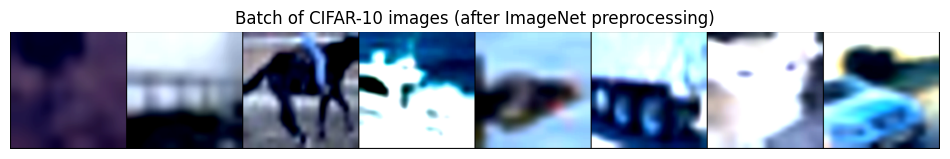

In [ ]:
import matplotlib.pyplot as plt
import torchvision

# Show CIFAR-10 original
dataiter = iter(train_loader)
images, labels = next(dataiter)

grid = torchvision.utils.make_grid(images[:8] / 2 + 0.5)
plt.figure(figsize=(12,4))
plt.imshow(grid.permute(1,2,0))
plt.title("Batch of CIFAR-10 images (after ImageNet preprocessing)")
plt.axis("off")


In [ ]:
!pip install -q fastervit timm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import time
from fastervit import create_model
from timm.data import resolve_data_config, create_transform
import random

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


Step 2 – Load CIFAR-10 with FasterViT preprocessing + show samples

We want CIFAR-10 images to go through the same style of transforms as ImageNet training (resize to 224, normalize, etc.).

Data config for FasterViT-0: {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
Train samples: 50000, Test samples: 10000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


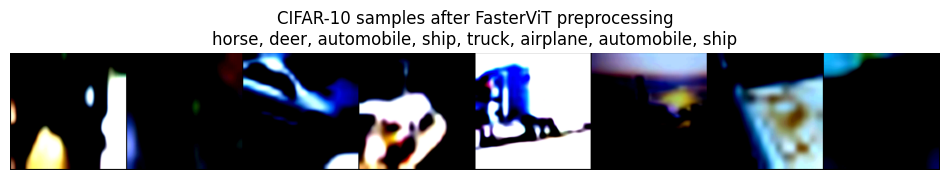

In [ ]:
# Temporary model just to get its pretrained data config
tmp_model = create_model("faster_vit_0_224", pretrained=True)
cfg = resolve_data_config(tmp_model.pretrained_cfg, model=tmp_model)
print("Data config for FasterViT-0:", cfg)

# Builds ImageNet-style transforms matching FasterViT pretraining
train_transform = create_transform(**cfg, is_training=True)
val_transform   = create_transform(**cfg, is_training=False)

# CIFAR-10 datasets
train_dataset = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=val_transform
)

BATCH_SIZE = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# ---- Show a few preprocessed images ----
classes = train_dataset.classes

def imshow_batch(images, labels, title):
    # images are normalized; roughly un-normalize for display
    imgs = images[:8].cpu()
    imgs = torch.clamp(imgs, 0, 1)  # they're already in [0,1] after create_transform
    grid = torchvision.utils.make_grid(imgs, nrow=8)
    npimg = grid.permute(1, 2, 0).numpy()

    plt.figure(figsize=(12, 3))
    plt.imshow(npimg)
    plt.axis("off")
    label_names = [classes[l] for l in labels[:8]]
    plt.title(title + "\n" + ", ".join(label_names))
    plt.show()

data_iter = iter(train_loader)
images, labels = next(data_iter)
imshow_batch(images, labels, "CIFAR-10 samples after FasterViT preprocessing")


Step 3 – Generic training + evaluation helper functions

Now we define reusable functions that will work for both FasterViT-0 and FasterViT-1.

In [ ]:
NUM_CLASSES = 10

def build_model(model_name):
    print(f"\n=== Building model {model_name} ===")
    model = create_model(
        model_name,
        pretrained=True,
    )
    # Replace classifier head: 1000 → 10
    if hasattr(model, "head") and isinstance(model.head, nn.Linear):
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, NUM_CLASSES)
    else:
        raise RuntimeError("Unexpected head structure.")

    model = model.to(device)
    return model

criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, optimizer, loader, epoch, scheduler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start = time.time()

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    if scheduler is not None:
        scheduler.step()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    elapsed = time.time() - start
    print(f"[Train] Epoch {epoch:02d} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}% | Time: {elapsed:.1f}s")
    return epoch_loss, epoch_acc

def evaluate(model, loader, desc="[Test ]"):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()

    test_loss = running_loss / total
    test_acc = 100.0 * correct / total
    print(f"{desc} Loss: {test_loss:.4f} | Acc: {test_acc:.2f}%")
    return test_loss, test_acc, all_labels, all_preds

def train_model(model_name, epochs=5, lr=3e-4, freeze_backbone=False):
    model = build_model(model_name)

    if freeze_backbone:
        for name, param in model.named_parameters():
            if not name.startswith("head"):
                param.requires_grad = False
        print("-> Backbone frozen; training head only.")

    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr, weight_decay=1e-4
    )
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    history = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

    best_acc = 0.0
    best_preds = None
    best_labels = None

    for epoch in range(1, epochs + 1):
        tl, ta = train_one_epoch(model, optimizer, train_loader, epoch, scheduler)
        vl, va, labels, preds = evaluate(model, test_loader)

        history["train_loss"].append(tl)
        history["train_acc"].append(ta)
        history["test_loss"].append(vl)
        history["test_acc"].append(va)

        if va > best_acc:
            best_acc = va
            best_labels = labels
            best_preds = preds
            torch.save(model.state_dict(), f"{model_name}_cifar10_best.pth")
            print(f"  -> New best accuracy: {best_acc:.2f}%, model saved.")

    print(f"\nBest test accuracy for {model_name}: {best_acc:.2f}%")
    return history, best_labels, best_preds


Step 4 – Train FasterViT-0 (full fine-tuning)

Now we re-do what you already did, but with history tracked and ready for plots.

In [ ]:
history_fvit0, labels_fvit0, preds_fvit0 = train_model(
    "faster_vit_0_224",
    epochs=5,          # you can set 10 if you want to squeeze a bit more
    lr=3e-4,
    freeze_backbone=False  # full fine-tuning
)



=== Building model faster_vit_0_224 ===
[Train] Epoch 01 | Loss: 0.6861 | Acc: 76.90% | Time: 359.7s
[Test ] Loss: 0.1330 | Acc: 95.73%
  -> New best accuracy: 95.73%, model saved.
[Train] Epoch 02 | Loss: 0.4704 | Acc: 84.11% | Time: 364.3s
[Test ] Loss: 0.0976 | Acc: 96.68%
  -> New best accuracy: 96.68%, model saved.
[Train] Epoch 03 | Loss: 0.3883 | Acc: 86.86% | Time: 364.0s
[Test ] Loss: 0.0953 | Acc: 96.87%
  -> New best accuracy: 96.87%, model saved.
[Train] Epoch 04 | Loss: 0.3315 | Acc: 88.67% | Time: 365.0s
[Test ] Loss: 0.0743 | Acc: 97.62%
  -> New best accuracy: 97.62%, model saved.
[Train] Epoch 05 | Loss: 0.2936 | Acc: 90.05% | Time: 364.4s
[Test ] Loss: 0.0656 | Acc: 98.00%
  -> New best accuracy: 98.00%, model saved.

Best test accuracy for faster_vit_0_224: 98.00%


Step 5 – Train FasterViT-1 (head-only, to show scaling effect)

To replicate “bigger model = better downstream performance” without burning too much compute, we’ll freeze the backbone and train only the head of FasterViT-1.

In [ ]:
history_fvit1, labels_fvit1, preds_fvit1 = train_model(
    "faster_vit_1_224",
    epochs=5,          # 5 is enough for head-only
    lr=3e-4,
    freeze_backbone=True
)



=== Building model faster_vit_1_224 ===


100%|██████████| 205M/205M [00:06<00:00, 31.8MB/s]


-> Backbone frozen; training head only.
[Train] Epoch 01 | Loss: 1.6421 | Acc: 56.40% | Time: 204.7s
[Test ] Loss: 0.7659 | Acc: 83.95%
  -> New best accuracy: 83.95%, model saved.
[Train] Epoch 02 | Loss: 1.1889 | Acc: 63.68% | Time: 202.1s
[Test ] Loss: 0.5546 | Acc: 85.50%
  -> New best accuracy: 85.50%, model saved.
[Train] Epoch 03 | Loss: 1.0829 | Acc: 65.17% | Time: 203.0s
[Test ] Loss: 0.4944 | Acc: 86.23%
  -> New best accuracy: 86.23%, model saved.
[Train] Epoch 04 | Loss: 1.0474 | Acc: 65.87% | Time: 203.3s
[Test ] Loss: 0.4730 | Acc: 86.60%
  -> New best accuracy: 86.60%, model saved.
[Train] Epoch 05 | Loss: 1.0367 | Acc: 65.71% | Time: 203.3s
[Test ] Loss: 0.4685 | Acc: 86.63%
  -> New best accuracy: 86.63%, model saved.

Best test accuracy for faster_vit_1_224: 86.63%


Step 6 – Plot training curves (both models)

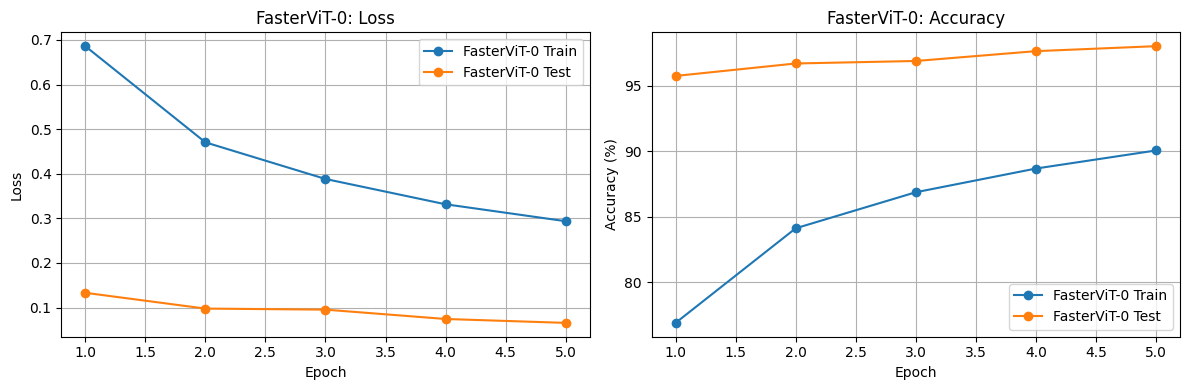

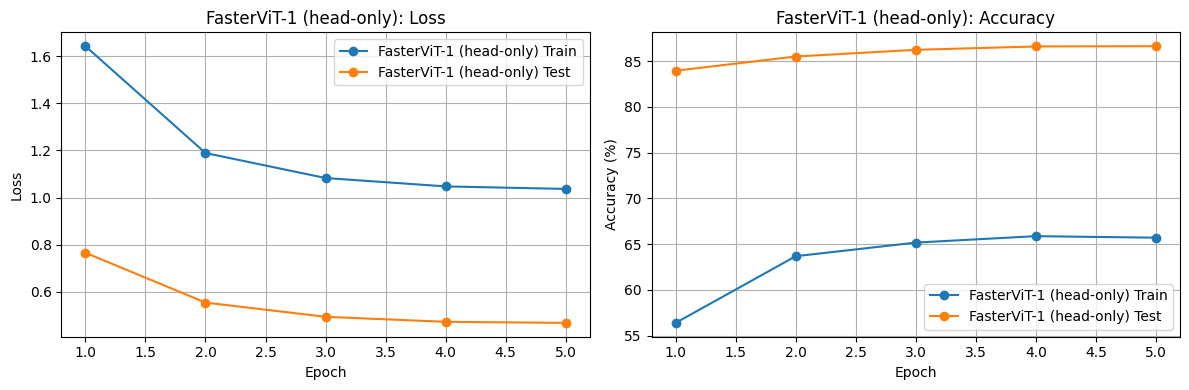

In [ ]:
def plot_history(history, label_prefix):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12,4))
    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], 'o-', label=f"{label_prefix} Train")
    plt.plot(epochs, history["test_loss"], 'o-', label=f"{label_prefix} Test")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{label_prefix}: Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], 'o-', label=f"{label_prefix} Train")
    plt.plot(epochs, history["test_acc"], 'o-', label=f"{label_prefix} Test")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{label_prefix}: Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_history(history_fvit0, "FasterViT-0")
plot_history(history_fvit1, "FasterViT-1 (head-only)")


Step 7 – Confusion matrix + classification report

Use the best predictions we saved during training.

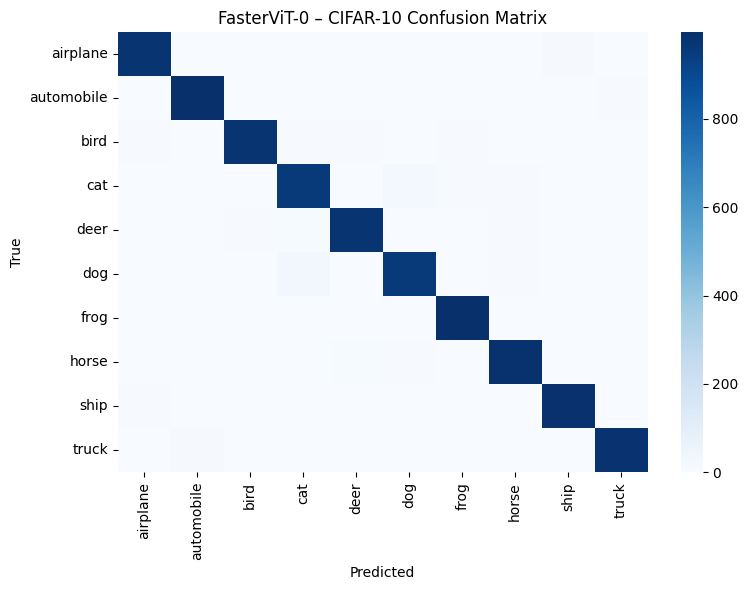


Classification report for FasterViT-0:
              precision    recall  f1-score   support

    airplane      0.987     0.980     0.983      1000
  automobile      0.984     0.995     0.990      1000
        bird      0.987     0.979     0.983      1000
         cat      0.951     0.959     0.955      1000
        deer      0.981     0.977     0.979      1000
         dog      0.967     0.956     0.961      1000
        frog      0.987     0.996     0.992      1000
       horse      0.983     0.985     0.984      1000
        ship      0.983     0.990     0.987      1000
       truck      0.990     0.983     0.986      1000

    accuracy                          0.980     10000
   macro avg      0.980     0.980     0.980     10000
weighted avg      0.980     0.980     0.980     10000



In [ ]:
import seaborn as sns  # Colab already has it, but if not: !pip install seaborn

def show_confusion_and_report(labels, preds, model_name):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=False, cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{model_name} – CIFAR-10 Confusion Matrix")
    plt.tight_layout()
    plt.show()

    print(f"\nClassification report for {model_name}:")
    print(classification_report(labels, preds, target_names=classes, digits=3))

show_confusion_and_report(labels_fvit0, preds_fvit0, "FasterViT-0")
# Optionally:
# show_confusion_and_report(labels_fvit1, preds_fvit1, "FasterViT-1 (head-only)")


Step 8 – Show sample predictions (qualitative results)


=== Building model faster_vit_0_224 ===


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


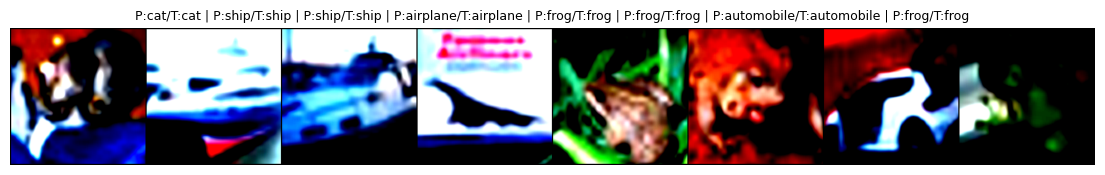

In [ ]:
def show_sample_predictions(model_name, weights_path, n_images=8):
    model = build_model(model_name)
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.eval()

    images, labels = next(iter(test_loader))
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = outputs.max(1)

    imgs = images[:n_images].cpu()
    grid = torchvision.utils.make_grid(imgs, nrow=n_images)
    npimg = grid.permute(1, 2, 0).numpy()

    plt.figure(figsize=(14,3))
    plt.imshow(npimg)
    plt.axis("off")
    titles = []
    for i in range(n_images):
        t = f"P:{classes[preds[i]]}/T:{classes[labels[i]]}"
        titles.append(t)
    plt.title(" | ".join(titles), fontsize=9)
    plt.show()

# Use the saved best model file
show_sample_predictions("faster_vit_0_224", "faster_vit_0_224_cifar10_best.pth")


# FasterViT vs SwinV2

In [ ]:
!nvidia-smi

!pip install -q fastervit timm torchmetrics


Sun Nov 30 01:33:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch, argparse

# Allow argparse.Namespace in torch.load safe-unpickler
torch.serialization.add_safe_globals([argparse.Namespace])
print("Registered argparse.Namespace as safe global.")

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
import timm
from fastervit import create_model

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Registered argparse.Namespace as safe global.


/usr/local/lib/python3.12/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Using device: cuda


CIFAR-10 dataset & transforms (ImageNet-style)

We’ll use standard ImageNet normalization and resize to 224×224 (what both models expect).

In [ ]:
# ImageNet-style normalization
IMNET_MEAN = (0.485, 0.456, 0.406)
IMNET_STD  = (0.229, 0.224, 0.225)

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMNET_MEAN, IMNET_STD),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMNET_MEAN, IMNET_STD),
])

train_dataset = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=test_transform
)

BATCH_SIZE = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print("Train samples:", len(train_dataset))
print("Test samples :", len(test_dataset))
print("Classes      :", train_dataset.classes)


100%|██████████| 170M/170M [00:21<00:00, 7.83MB/s]


Train samples: 50000
Test samples : 10000
Classes      : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Build models (FasterViT-0 & Swin Tiny for 10 classes)

Here we create:

FasterViT-0 with ImageNet pretrained weights and replace head to 10 classes

Swin Tiny 224 with ImageNet pretrained weights and 10-class head

In [ ]:
NUM_CLASSES = 10

# ---------- FasterViT-0 ----------
fvit = create_model("faster_vit_0_224", pretrained=True).to(device)

# Replace head to 10 classes
if hasattr(fvit, "head") and isinstance(fvit.head, nn.Linear):
    in_features = fvit.head.in_features
    fvit.head = nn.Linear(in_features, NUM_CLASSES).to(device)
else:
    raise RuntimeError("Unexpected FasterViT head structure")

# ---------- Swin Tiny (224) ----------
swin = timm.create_model(
    "swin_tiny_patch4_window7_224",
    pretrained=True,
    num_classes=NUM_CLASSES
).to(device)

print("FasterViT-0 and Swin Tiny are ready.")


/usr/local/lib/python3.12/dist-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 361M/361M [00:01<00:00, 194MB/s]
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

FasterViT-0 and Swin Tiny are ready.


Cell 5 – Generic train & eval functions

These will be reused for both models.

In [ ]:
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader, optimizer, epoch, model_name="Model"):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start = time.time()

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    elapsed = time.time() - start

    print(f"[{model_name} Train] Epoch {epoch:02d} | Loss={epoch_loss:.4f} | Acc={epoch_acc:.2f}% | Time={elapsed:.1f}s")
    return epoch_loss, epoch_acc

def evaluate(model, loader, model_name="Model"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    avg_loss = running_loss / total
    acc = 100.0 * correct / total
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    print(f"[{model_name} Eval ] Loss={avg_loss:.4f} | Acc={acc:.2f}%")
    return avg_loss, acc, all_preds, all_labels


Train FasterViT-0 on CIFAR-10

In [ ]:
EPOCHS_FVIT = 5  # you can increase to 10 if GPU is fast

optimizer_fvit = optim.AdamW(fvit.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler_fvit = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_fvit, T_max=EPOCHS_FVIT)

best_fvit_acc = 0.0

for epoch in range(1, EPOCHS_FVIT + 1):
    train_one_epoch(fvit, train_loader, optimizer_fvit, epoch, model_name="FasterViT-0")
    scheduler_fvit.step()
    val_loss, val_acc, _, _ = evaluate(fvit, test_loader, model_name="FasterViT-0")

    if val_acc > best_fvit_acc:
        best_fvit_acc = val_acc
        torch.save(fvit.state_dict(), "fastervit0_cifar10_best.pth")
        print(f"  -> New BEST FasterViT-0 accuracy: {best_fvit_acc:.2f}% (model saved)")

print("\nFinal BEST FasterViT-0 CIFAR-10 accuracy:", best_fvit_acc)


[FasterViT-0 Train] Epoch 01 | Loss=0.6394 | Acc=78.66% | Time=371.0s
[FasterViT-0 Eval ] Loss=0.1438 | Acc=95.35%
  -> New BEST FasterViT-0 accuracy: 95.35% (model saved)
[FasterViT-0 Train] Epoch 02 | Loss=0.4163 | Acc=85.78% | Time=386.4s
[FasterViT-0 Eval ] Loss=0.1156 | Acc=96.48%
  -> New BEST FasterViT-0 accuracy: 96.48% (model saved)
[FasterViT-0 Train] Epoch 03 | Loss=0.3358 | Acc=88.63% | Time=387.1s
[FasterViT-0 Eval ] Loss=0.0944 | Acc=96.92%
  -> New BEST FasterViT-0 accuracy: 96.92% (model saved)
[FasterViT-0 Train] Epoch 04 | Loss=0.2803 | Acc=90.52% | Time=387.4s
[FasterViT-0 Eval ] Loss=0.0772 | Acc=97.52%
  -> New BEST FasterViT-0 accuracy: 97.52% (model saved)
[FasterViT-0 Train] Epoch 05 | Loss=0.2441 | Acc=91.72% | Time=387.5s
[FasterViT-0 Eval ] Loss=0.0685 | Acc=97.74%
  -> New BEST FasterViT-0 accuracy: 97.74% (model saved)

Final BEST FasterViT-0 CIFAR-10 accuracy: 97.74


Train Swin Tiny on CIFAR-10

In [ ]:
EPOCHS_SWIN = 5  # match FasterViT epochs

optimizer_swin = optim.AdamW(swin.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler_swin = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_swin, T_max=EPOCHS_SWIN)

best_swin_acc = 0.0

for epoch in range(1, EPOCHS_SWIN + 1):
    train_one_epoch(swin, train_loader, optimizer_swin, epoch, model_name="Swin-Tiny")
    scheduler_swin.step()
    val_loss, val_acc, _, _ = evaluate(swin, test_loader, model_name="Swin-Tiny")

    if val_acc > best_swin_acc:
        best_swin_acc = val_acc
        torch.save(swin.state_dict(), "swin_cifar10_best.pth")
        print(f"  -> New BEST Swin-Tiny accuracy: {best_swin_acc:.2f}% (model saved)")

print("\nFinal BEST Swin-Tiny CIFAR-10 accuracy:", best_swin_acc)


[Swin-Tiny Train] Epoch 01 | Loss=0.6424 | Acc=77.89% | Time=637.4s
[Swin-Tiny Eval ] Loss=0.2088 | Acc=93.07%
  -> New BEST Swin-Tiny accuracy: 93.07% (model saved)
[Swin-Tiny Train] Epoch 02 | Loss=0.4644 | Acc=84.20% | Time=636.8s
[Swin-Tiny Eval ] Loss=0.1655 | Acc=94.18%
  -> New BEST Swin-Tiny accuracy: 94.18% (model saved)
[Swin-Tiny Train] Epoch 03 | Loss=0.3732 | Acc=87.21% | Time=637.4s
[Swin-Tiny Eval ] Loss=0.1202 | Acc=95.97%
  -> New BEST Swin-Tiny accuracy: 95.97% (model saved)
[Swin-Tiny Train] Epoch 04 | Loss=0.2896 | Acc=90.08% | Time=638.8s
[Swin-Tiny Eval ] Loss=0.1046 | Acc=96.72%
  -> New BEST Swin-Tiny accuracy: 96.72% (model saved)
[Swin-Tiny Train] Epoch 05 | Loss=0.2365 | Acc=91.94% | Time=637.8s
[Swin-Tiny Eval ] Loss=0.0788 | Acc=97.56%
  -> New BEST Swin-Tiny accuracy: 97.56% (model saved)

Final BEST Swin-Tiny CIFAR-10 accuracy: 97.56


Reload best models & detailed comparison

=== Final Evaluation on CIFAR-10 test set ===
[FasterViT-0 (best) Eval ] Loss=0.0685 | Acc=97.74%
[Swin-Tiny (best) Eval ] Loss=0.0788 | Acc=97.56%

SUMMARY ACCURACY
FasterViT-0  Test Acc: 97.74%
Swin-Tiny    Test Acc: 97.56%


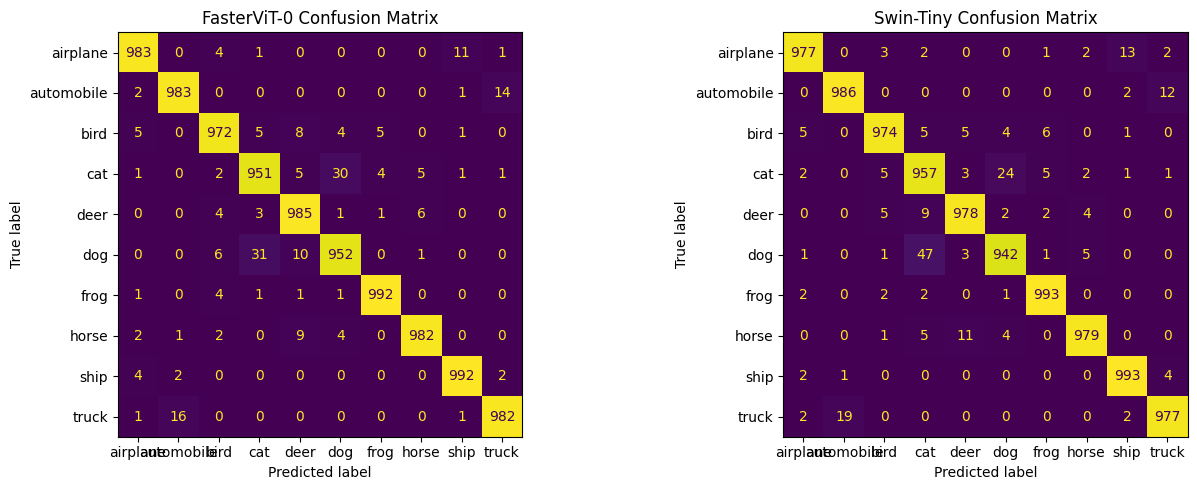

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


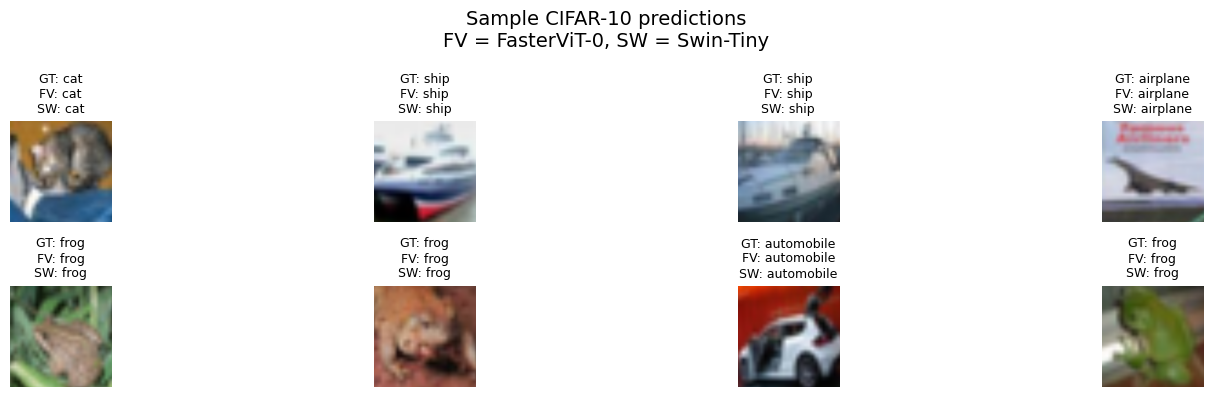

In [ ]:
# ---------- Reload best models ----------
fvit_best = create_model("faster_vit_0_224", pretrained=False).to(device)
# replace head to 10 classes
in_features = fvit_best.head.in_features
fvit_best.head = nn.Linear(in_features, NUM_CLASSES).to(device)
fvit_best.load_state_dict(torch.load("fastervit0_cifar10_best.pth", map_location=device))
fvit_best.eval()

swin_best = timm.create_model(
    "swin_tiny_patch4_window7_224",
    pretrained=False,
    num_classes=NUM_CLASSES
).to(device)
swin_best.load_state_dict(torch.load("swin_cifar10_best.pth", map_location=device))
swin_best.eval()

# ---------- Evaluate both ----------
print("=== Final Evaluation on CIFAR-10 test set ===")
fvit_loss, fvit_acc, fvit_preds, fvit_labels = evaluate(fvit_best, test_loader, "FasterViT-0 (best)")
swin_loss, swin_acc, swin_preds, swin_labels = evaluate(swin_best, test_loader, "Swin-Tiny (best)")

print("\nSUMMARY ACCURACY")
print(f"FasterViT-0  Test Acc: {fvit_acc:.2f}%")
print(f"Swin-Tiny    Test Acc: {swin_acc:.2f}%")

# ---------- Confusion matrices ----------
class_names = test_dataset.classes

cm_fvit = confusion_matrix(fvit_labels, fvit_preds)
cm_swin = confusion_matrix(swin_labels, swin_preds)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

disp1 = ConfusionMatrixDisplay(cm_fvit, display_labels=class_names)
disp1.plot(ax=axes[0], values_format='d', colorbar=False)
axes[0].set_title("FasterViT-0 Confusion Matrix")

disp2 = ConfusionMatrixDisplay(cm_swin, display_labels=class_names)
disp2.plot(ax=axes[1], values_format='d', colorbar=False)
axes[1].set_title("Swin-Tiny Confusion Matrix")

plt.tight_layout()
plt.show()

# ---------- Sample prediction visualization ----------
def show_sample_predictions(model1, model2, n_samples=8):
    model1.eval()
    model2.eval()

    images, labels = next(iter(test_loader))
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        out1 = model1(images)
        out2 = model2(images)
        _, preds1 = out1.max(1)
        _, preds2 = out2.max(1)

    images = images.cpu()
    labels = labels.cpu()
    preds1 = preds1.cpu()
    preds2 = preds2.cpu()

    plt.figure(figsize=(16, 4))
    for i in range(n_samples):
        img = images[i]
        # roughly unnormalize for display
        img = img * torch.tensor(IMNET_STD).view(3,1,1) + torch.tensor(IMNET_MEAN).view(3,1,1)
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        gt = class_names[labels[i].item()]
        p1 = class_names[preds1[i].item()]
        p2 = class_names[preds2[i].item()]

        plt.subplot(2, n_samples//2, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"GT: {gt}\nFV: {p1}\nSW: {p2}", fontsize=9)

    plt.suptitle("Sample CIFAR-10 predictions\nFV = FasterViT-0, SW = Swin-Tiny", fontsize=14)
    plt.tight_layout()
    plt.show()

show_sample_predictions(fvit_best, swin_best, n_samples=8)


Throughput comparison (Experiment 1 style)

Now we do a pure throughput test on the same GPU, same batch size, same 224×224 input.

In [ ]:
def benchmark_model(model, name, batch_size=64, image_size=224, iters=50):
    model.eval()
    dummy = torch.randn(batch_size, 3, image_size, image_size).to(device)

    # Warm-up
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy)
    if device == "cuda":
        torch.cuda.synchronize()

    start = time.time()
    with torch.no_grad():
        for _ in range(iters):
            _ = model(dummy)
    if device == "cuda":
        torch.cuda.synchronize()
    end = time.time()

    total_images = batch_size * iters
    throughput = total_images / (end - start)
    print(f"[{name}] Processed {total_images} images in {end - start:.3f}s")
    print(f"[{name}] Throughput: {throughput:.2f} images/sec")
    return throughput

print("=== Throughput Benchmark (ImageNet-style, 224x224) ===")

# Use the *best* models we already built (weights don't change speed much)
throughput_fvit = benchmark_model(fvit_best, "FasterViT-0")
throughput_swin = benchmark_model(swin_best, "Swin-Tiny")

print("\n=== THROUGHPUT SUMMARY ===")
print(f"FasterViT-0 throughput: {throughput_fvit:.2f} img/s")
print(f"Swin-Tiny   throughput: {throughput_swin:.2f} img/s")
print(f"Speedup (FasterViT / Swin): {throughput_fvit / throughput_swin:.2f}×")


=== Throughput Benchmark (ImageNet-style, 224x224) ===


NameError: name 'fvit_best' is not defined